In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
train=pd.read_csv(f"/content/drive/MyDrive/My datasets/02-14-2018.csv")

In [33]:
train.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  int64  
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [35]:
train.shape

(1048575, 80)

In [36]:
train.isnull().sum()

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64

In [37]:
# total = train.shape[0]
# missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
# for col in missing_columns:
#     null_count = train[col].isnull().sum()
#     per = (null_count/total) * 100
#     print(f"{col}: {null_count} ({round(per, 3)}%)")

Flow Byts/s: 2277 (0.217%)


In [38]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 225628


In [39]:
# Remove duplicate rows
df_no_duplicates = train.drop_duplicates()

# Display the DataFrame after removing duplicates
print("\nDataFrame after removing duplicates:")
print(df_no_duplicates)


DataFrame after removing duplicates:
         Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0               0         0  14/02/2018 08:31:01      112641719             3   
1               0         0  14/02/2018 08:33:50      112641466             3   
2               0         0  14/02/2018 08:36:39      112638623             3   
3              22         6  14/02/2018 08:40:13        6453966            15   
4              22         6  14/02/2018 08:40:23        8804066            14   
...           ...       ...                  ...            ...           ...   
1048570        80         6  14/02/2018 10:53:23       10156986             5   
1048571        80         6  14/02/2018 10:53:33            117             2   
1048572        80         6  14/02/2018 10:53:28        5095331             3   
1048573        80         6  14/02/2018 10:53:28        5235511             3   
1048574       443         6  14/02/2018 10:53:28        5807256        

In [40]:
# Find and remove NaN values
df_no_nan = train.dropna()

# Find and remove infinity values
train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_no_inf = train.dropna()

# Display DataFrames after removing NaN and infinity values
print("\nDataFrame after removing NaN values:")
print(df_no_nan)

print("\nDataFrame after removing infinity values:")
print(df_no_inf)



DataFrame after removing NaN values:
         Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0               0         0  14/02/2018 08:31:01      112641719             3   
1               0         0  14/02/2018 08:33:50      112641466             3   
2               0         0  14/02/2018 08:36:39      112638623             3   
3              22         6  14/02/2018 08:40:13        6453966            15   
4              22         6  14/02/2018 08:40:23        8804066            14   
...           ...       ...                  ...            ...           ...   
1048570        80         6  14/02/2018 10:53:23       10156986             5   
1048571        80         6  14/02/2018 10:53:33            117             2   
1048572        80         6  14/02/2018 10:53:28        5095331             3   
1048573        80         6  14/02/2018 10:53:28        5235511             3   
1048574       443         6  14/02/2018 10:53:28        5807256        

In [41]:
train.shape

(1048575, 80)

In [70]:
# List of unnecessary columns
columns_to_remove = [
    'Timestamp', 'Flow Byts/s', 'Flow Pkts/s', 'Fwd Pkts/s', 'Bwd Pkts/s',
    'Pkt Len Var', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Bwd Blk Rate Avg', 'CWE Flag Count'
]

# Drop unnecessary columns
print("Columns before removal:", train.columns)
df = train.drop(columns=columns_to_remove, errors='ignore')
print("Columns after removal:", train.columns)

Columns before removal: Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio'

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  int64  
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

<Axes: xlabel='Label', ylabel='count'>

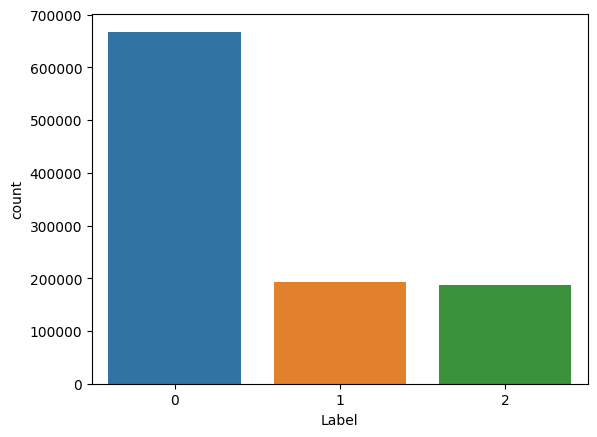

In [60]:
sns.countplot(x=train['Label'])

In [61]:
print('Class distribution Training set:')
print(train['Label'].value_counts())

Class distribution Training set:
0    667626
1    193360
2    187589
Name: Label, dtype: int64


In [62]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)

In [63]:
# train.drop(['num_outbound_cmds'], axis=1, inplace=True)
# test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [64]:
train.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,15905,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,0
1,0,0,16074,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,0
2,0,0,16243,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,0
3,22,6,16457,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0
4,22,6,16467,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0


In [65]:
Y_train = train[['Label']]
X_train = train.drop(['Label'], axis=1)

Y_train.shape

(1048575, 1)

In [66]:
from keras.utils import to_categorical

# Assuming y is your label column
y_one_hot = to_categorical(Y_train, num_classes=3)

In [49]:
print("Shape of x_train:", X_train.shape)
print("Shape of y_train_one_hot:", y_one_hot.shape)
print("Sample labels in y_train_one_hot:", y_one_hot[:5])

Shape of x_train: (1048575, 79)
Shape of y_train_one_hot: (1048575, 3)
Sample labels in y_train_one_hot: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


Using Artificial Neural Network layers to solve the binary classification problem

In [50]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
# test = scale.fit_transform(test)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X_train, y_one_hot, train_size=0.70, random_state=2)

In [52]:
x_train.shape

(734002, 79)

In [53]:
x_test.shape

(314573, 79)

In [54]:
y_train.shape

(734002, 3)

In [55]:
y_test.shape

(314573, 3)

Gaussian Naive Bayes

In [56]:

# Create a Sequential model
model = Sequential()

# # Input layer
# model.add(Dense(units=128, activation='relu', input_shape=(40,)))

# # Hidden layers
# model.add(Dense(units=64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(units=32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(units=16, activation='relu'))
# model.add(BatchNormalization())

# # Output layer
# model.add(Dense(units=1, activation='sigmoid'))

# # Use a learning rate scheduler
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
# # Compile the model with the Adam optimizer and a lower learning rate
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


model.add(Dense(units=150, activation='relu', input_shape=(79,)))
# First hidden layer
model.add(Dense(units=79, activation='relu'))
model.add(BatchNormalization())
# Second hidden layer
model.add(Dense(units=40, activation='relu'))
model.add(BatchNormalization())
# Third hidden layer
model.add(Dense(units=20, activation='relu'))
model.add(BatchNormalization())
# Output layer
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to see the architecture and parameters
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 150)               12000     
                                                                 
 dense_6 (Dense)             (None, 79)                11929     
                                                                 
 batch_normalization_3 (Bat  (None, 79)                316       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 40)                3200      
                                                                 
 batch_normalization_4 (Bat  (None, 40)                160       
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 20)               

In [58]:
# Train the model
history = model.fit(x_train, y_train, epochs=40, batch_size=32)

Epoch 1/40
22938/22938 [==============================] - 147s 6ms/step - loss: nan - accuracy: 0.6367
Epoch 2/40
22938/22938 [==============================] - 148s 6ms/step - loss: nan - accuracy: 0.6367
Epoch 3/40
22938/22938 [==============================] - 146s 6ms/step - loss: nan - accuracy: 0.6367
Epoch 4/40
22938/22938 [==============================] - 148s 6ms/step - loss: nan - accuracy: 0.6367
Epoch 5/40
22938/22938 [==============================] - 149s 7ms/step - loss: nan - accuracy: 0.6367
Epoch 6/40
22938/22938 [==============================] - 146s 6ms/step - loss: nan - accuracy: 0.6367
Epoch 7/40
22938/22938 [==============================] - 145s 6ms/step - loss: nan - accuracy: 0.6367
Epoch 8/40
22938/22938 [==============================] - 147s 6ms/step - loss: nan - accuracy: 0.6367
Epoch 9/40
22938/22938 [==============================] - 149s 7ms/step - loss: nan - accuracy: 0.6367
Epoch 10/40
22938/22938 [==============================] - 146s 6ms/step 

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

237/237 [==============================] - 0s 1ms/step - loss: 0.1433 - accuracy: 0.9927
Test Loss: 0.14333464205265045, Test Accuracy: 0.9927229285240173
